# 1. Introdução

A proposta desse projeto é mostrar como se utilizar o Método de Monte Carlo (MMC) para tentar prever a evolução dos preços de um ativo - ou carteira de
ativos - através dos seus dados históricos.

Veremos também que as conclusões retiradas pelos resultados da aplicação desse método podem ser enganosas, uma vez que o MMC assume que os dados apresentam uma distribuição normal e, portanto, as evoluções de preços no futuro deverão ser algo próximo ao que foi visto no passado.



# 2. Desenvolvimento do Código

Inicialmente, iremos fazer a importação das bibliotecas utilizadas.

In [260]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Para essa análise, utilizarei a biblioteca do Yahoo Finance importada anteriormente para trazer as ações do Itaú (ITUB4).
Utilizarei o ano de 2023 para encontrar as informações históricas fazer as simulações, tentando prever o que acontecerá no próximo ano.

In [261]:
ativo = "ITUB4"
dados = yf.download(ativo+'.SA', start="2023-01-01", end="2023-12-31")
dados

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-02,24.430000,24.530001,24.040001,24.490000,22.039671,23340700
2023-01-03,24.490000,24.650000,23.830000,23.980000,21.580702,29873800
2023-01-04,24.059999,24.520000,23.879999,24.049999,21.643700,29881500
2023-01-05,24.100000,24.910000,24.020000,24.799999,22.318657,36322800
2023-01-06,24.930000,25.309999,24.799999,25.230000,22.705635,37628200
...,...,...,...,...,...,...
2023-12-21,32.750000,32.869999,32.549999,32.790001,30.883232,21813000
2023-12-22,32.820000,33.540001,32.799999,33.310001,31.372995,32650500
2023-12-26,33.369999,33.779999,33.230000,33.650002,31.693230,23135400


Para esse estudo não utilizarei as informações de fechamento ajustado, uma vez que não quero assumir o impacto do ganho de dividendos no preço e também porque não houve nenhum split no período.


---

Aqui também tomei o cuidado de utilizar o retorno logaritmico, uma vez que ele tem várias vantagens sobre os retornos simples.


*   Aditividade dos Retornos: Isso significa que, para calcular o retorno total de um período, você pode simplesmente somar os retornos logarítmicos de cada subperíodo. No exemplo da equação abaixo, temos um ganho de 10% no dia 1, e mais 5% no dia dois, sendo calculado como:

\begin{equation}
Retorno\ \log\ total = \ln(1 + 0.10) + \ln(1 + 0.05)
\end{equation}

*   Normalidade dos Retornos: Retornos logarítmicos tendem a ser mais próximos de uma distribuição normal do que os retornos simples. Muitas das premissas estatísticas e métodos de simulação (como Monte Carlo) funcionam melhor quando os dados seguem uma distribuição normal, ou ao menos se aproximam disso.

*   Comparação mais fácil entre ativos: O retorno logarítmico é simétrico em torno de 0. Ou seja, um aumento de 10% e uma queda de 10% não são exatamente inversos no retorno simples, mas são em retornos logarítmicos. Isso facilita a interpretação de perdas e ganhos em análises comparativas.

In [262]:
dados['Retorno'] = np.log(dados['Close'] / dados['Close'].shift(1))
dados

,Open,High,Low,Close,Adj Close,Volume,Retorno
Date,,,,,,,
2023-01-02,24.430000,24.530001,24.040001,24.490000,22.039671,23340700,NaN
2023-01-03,24.490000,24.650000,23.830000,23.980000,21.580702,29873800,-0.021045
2023-01-04,24.059999,24.520000,23.879999,24.049999,21.643700,29881500,0.002915
2023-01-05,24.100000,24.910000,24.020000,24.799999,22.318657,36322800,0.030709
2023-01-06,24.930000,25.309999,24.799999,25.230000,22.705635,37628200,0.017190
...,...,...,...,...,...,...,...
2023-12-21,32.750000,32.869999,32.549999,32.790001,30.883232,21813000,0.006732
2023-12-22,32.820000,33.540001,32.799999,33.310001,31.372995,32650500,0.015734
2023-12-26,33.369999,33.779999,33.230000,33.650002,31.693230,23135400,0.010155


In [263]:
# Calcular o retorno esperado e a volatilidade anualizada
retorno_esperado = dados['Retorno'].mean()
volatilidade = dados['Retorno'].std()
dias = 252 # 252 dias úteis no ano

retorno_esperado_anualizado = retorno_esperado * dias
volatilidade_anualizada = volatilidade * np.sqrt(dias)

print('Retorno Esperado Diário ',retorno_esperado)
print('Retorno Esperado Anualizado ',retorno_esperado_anualizado)
print('Volatilidade Diária',volatilidade)
print('Volatilidade Anualizada',volatilidade_anualizada)

Retorno Esperado Diário  0.0013247488116967044
Retorno Esperado Anualizado  0.3338367005475695
Volatilidade Diária 0.014671661795980359
Volatilidade Anualizada 0.2329054105932678


In [264]:
# Parâmetros da simulação
preco_inicial = dados['Close'].iloc[-1]  # Último preço ajustado
anos = 12  # Prazo da previsão (1 ano)
simulacoes = 1000  # Número de simulações
dias_a_simular = 252  # Simular 1 ano (252 dias úteis)

In [265]:
# Criando os preços e retornos aleatórios.

precos_simulados = np.zeros((dias_a_simular, simulacoes))
retornos_acumulados = np.zeros((dias_a_simular, simulacoes))

precos_simulados[0] = preco_inicial  # Preço inicial para todas as simulações
retornos_acumulados[0] = 0  # Retorno inicial acumulado é zero

for i in range(1, dias_a_simular):
    retornos_aleatorios = np.random.normal(retorno_esperado, volatilidade, simulacoes)
    precos_simulados[i] = precos_simulados[i-1] * np.exp(retornos_aleatorios)
    retornos_acumulados[i] = retornos_acumulados[i-1] + retornos_aleatorios  # Soma os retornos diários

df_retornos_acumulados = pd.DataFrame(retornos_acumulados)
df_precos_simulados = pd.DataFrame(precos_simulados)

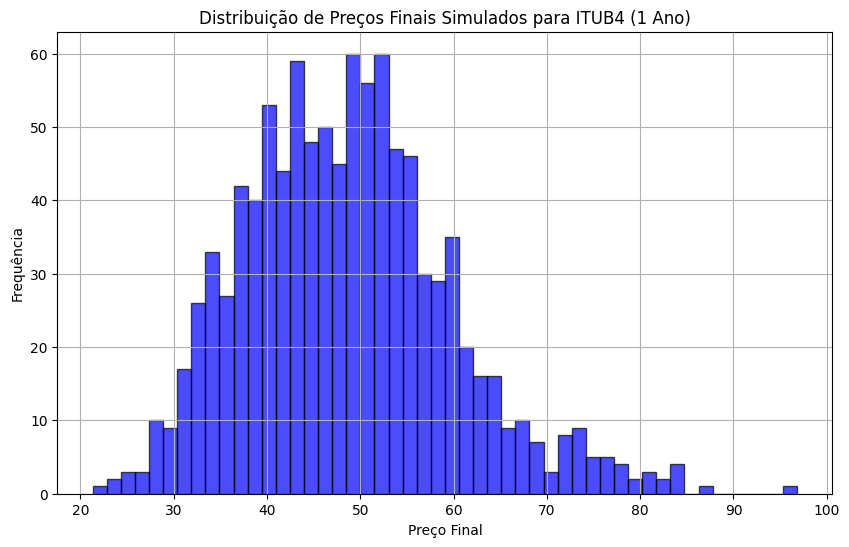

In [266]:
# Plotar a distribuição dos preços finais simulados
plt.figure(figsize=(10, 6))
plt.hist(df_precos_simulados.iloc[-1], bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title(f'Distribuição de Preços Finais Simulados para {ativo} (1 Ano)')
plt.xlabel('Preço Final')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

In [267]:
# Calcular estatísticas importantes
preco_medio = np.mean(df_precos_simulados.iloc[-1])
preco_median = np.median(df_precos_simulados.iloc[-1])
percentil_5 = np.percentile(df_precos_simulados.iloc[-1], 5)
percentil_95 = np.percentile(df_precos_simulados.iloc[-1], 95)

print('Preço Médio',preco_medio)
print('Preço Mediana',preco_median)
print('Percentil 5',percentil_5)
print('Percentil 95',percentil_95)

Preço Médio 48.56078748565649
Preço Mediana 48.05680531554627
Percentil 5 32.070253789495375
Percentil 95 68.60613982964503


No histograma acima, é possível analisar a ditribuição de frequência dos preços finais simulados pelo MMC.

Aqui, a média é maior que a mediana, o que indica a existência simualações rentáveis (preços finais maiores que os preços iniciais) com mais frequência.

---

Em seguida, é interessante plotar todas as curvas de evolução de preços e de retornos simuladas.

Fizemos 1000 simulações, então devemos ter mil curvas para cada indicador.

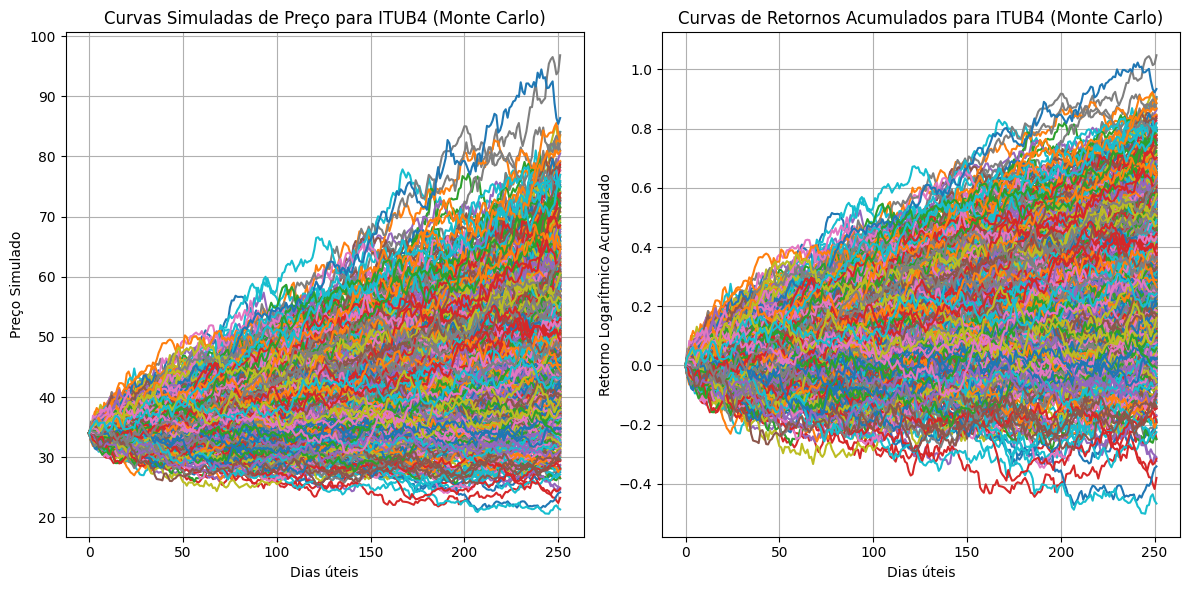

In [268]:
# Plotar as curvas simuladas de preço e retorno

# Curvas de evolução no Preço

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(simulacoes):
    plt.plot(precos_simulados[:, i], lw=1.5)

plt.title(f'Curvas Simuladas de Preço para {ativo} (Monte Carlo)')
plt.xlabel('Dias úteis')
plt.ylabel('Preço Simulado')
plt.grid(True)

# Curvas de evolução no retorno
plt.subplot(1, 2, 2)
for i in range(simulacoes):
    plt.plot(retornos_acumulados[:, i], lw=1.5)

plt.title(f'Curvas de Retornos Acumulados para {ativo} (Monte Carlo)')
plt.xlabel('Dias úteis')
plt.ylabel('Retorno Logarítmico Acumulado')
plt.grid(True)

plt.tight_layout()
plt.show()

In [269]:
# Calcular estatísticas importantes
df_retornos_acumulados_transposed = df_retornos_acumulados.T
retornos_positivos = df_retornos_acumulados_transposed[df_retornos_acumulados_transposed.iloc[:,-1] > 0].shape[0]

print(f'Retornos Positivos em um ano: {retornos_positivos}, um total de {(retornos_positivos/simulacoes)*100:.2f}% das simulações feitas')

Retornos Positivos em um ano: 918, um total de 91.80% das simulações feitas


Vemos um volume muito grande de curvas se mostarndo positivas. Isso ocorre porque a simulação leva em consideração os indicadores hirtóricos para desenvolver a simulação (Retorno Esperado e Volatilidade), então caso o ativo do Itaú tenha o mesmo comportamento do passado, teremos boas perspectivas.

# 3. Comparação com o realizado

Agora farei uma comparação do realizado com o simulado. Para isso, utilizarei os dados realizados até o momento de 2024.

In [270]:
dados2 = yf.download(ativo+'.SA', start="2024-01-01")
dados2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,33.889999,33.889999,33.240002,33.520000,31.587200,18948200
2024-01-03,33.509998,33.770000,33.150002,33.150002,31.238539,18530900
2024-01-04,33.150002,33.230000,32.700001,32.930000,31.031219,26585200
2024-01-05,32.910000,33.700001,32.880001,33.700001,31.756819,27726400
2024-01-08,33.520000,33.669998,33.290001,33.340000,31.417583,11810700
...,...,...,...,...,...,...
2024-10-11,34.830002,34.970001,34.549999,34.630001,34.630001,16968500
2024-10-14,34.740002,35.070000,34.619999,34.849998,34.849998,14436100
2024-10-15,34.900002,35.310001,34.730000,35.250000,35.250000,28801300


In [271]:
# Calculando os retornos reais

dados2['Retorno'] = np.log(dados2['Close'] / dados2['Close'].shift(1))
dados2['Retorno'] = dados2['Retorno'].fillna(0)
dados2['Retorno_acumulado'] = dados2['Retorno'].cumsum()
dados2.reset_index(inplace=True)
dados2

,Date,Open,High,Low,Close,Adj Close,Volume,Retorno,Retorno_acumulado
0,2024-01-02,33.889999,33.889999,33.240002,33.520000,31.587200,18948200,0.000000,0.000000
1,2024-01-03,33.509998,33.770000,33.150002,33.150002,31.238539,18530900,-0.011100,-0.011100
2,2024-01-04,33.150002,33.230000,32.700001,32.930000,31.031219,26585200,-0.006659,-0.017758
3,2024-01-05,32.910000,33.700001,32.880001,33.700001,31.756819,27726400,0.023114,0.005356
4,2024-01-08,33.520000,33.669998,33.290001,33.340000,31.417583,11810700,-0.010740,-0.005384
...,...,...,...,...,...,...,...,...,...
198,2024-10-11,34.830002,34.970001,34.549999,34.630001,34.630001,16968500,-0.007480,0.032578
199,2024-10-14,34.740002,35.070000,34.619999,34.849998,34.849998,14436100,0.006333,0.038911
200,2024-10-15,34.900002,35.310001,34.730000,35.250000,35.250000,28801300,0.011412,0.050323
201,2024-10-16,35.250000,35.270000,34.849998,35.040001,35.040001,34988700,-0.005975,0.044348


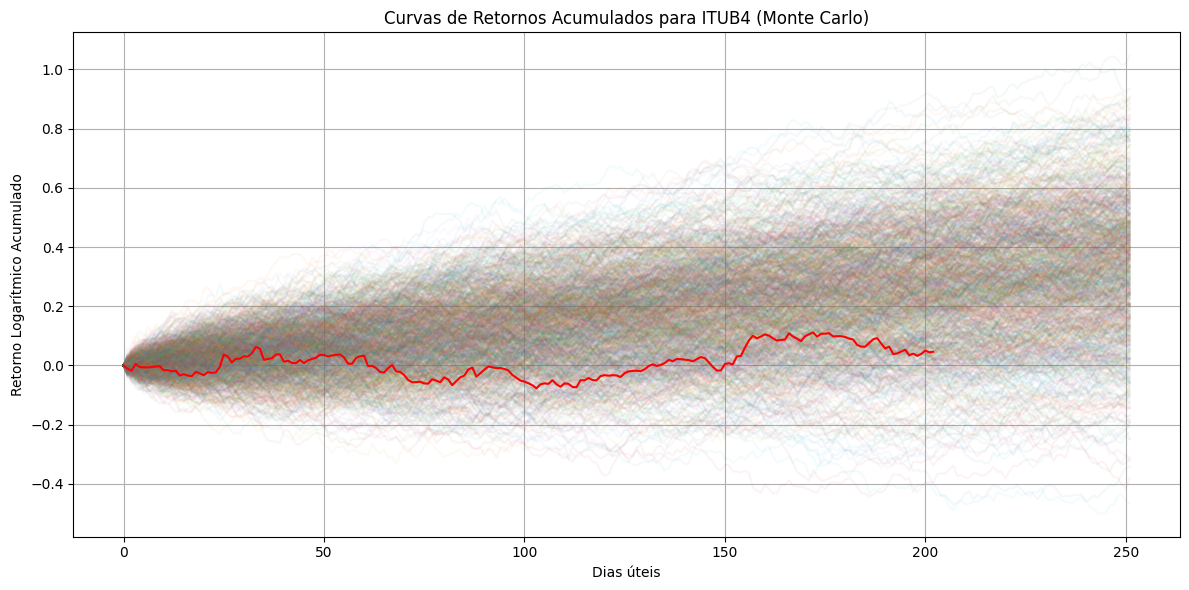

In [272]:
plt.figure(figsize=(12, 6))

for i in range(simulacoes):
    plt.plot(retornos_acumulados[:, i], lw=1.5, alpha=0.05)
plt.plot(dados2['Retorno_acumulado'], lw=1.5, color='red')

plt.title(f'Curvas de Retornos Acumulados para {ativo} (Monte Carlo)')
plt.xlabel('Dias úteis')
plt.ylabel('Retorno Logarítmico Acumulado')
plt.grid(True)

plt.tight_layout()
plt.show()

Nesse backtest, a curva em vermelho escura é a informação realizada. Dessa forma, podemos ver que os retornos do ativo estão dentro do range possível simulado pelo MMC, o que indica que a ação pode estar apresentando um comportamento próximo ao que apresentou no ano passado.